# Kmeans + F + Xgboost


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cluster import KMeans

# -------------------------
# Ön İşlem ve Veri Hazırlığı
# -------------------------
# Veri setini yükleyip gereksiz sütunları kaldırıyoruz.
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerlerin düzenlenmesi
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özniteliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)


n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
# Küme bilgilerini ölçeklendirilmiş veri setine ekliyoruz.
X_scaled['Cluster'] = clusters

print("Kümeleme işlemi tamamlandı. Küme dağılımı:")
print(pd.Series(clusters).value_counts())

Kümeleme işlemi tamamlandı. Küme dağılımı:
1    521
0    391
3    361
2    301
4    118
Name: count, dtype: int64


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [ ]:

# Her kğmenin tahminleri 
all_predictions = pd.Series(index=y.index, dtype=float)
cluster_metrics = {}

for cluster in np.unique(clusters):
    print(f"\nCluster {cluster} için model eğitimi başlatılıyor...")

    cluster_mask = X_scaled['Cluster'] == cluster
    X_cluster = X_scaled.loc[cluster_mask].drop(columns=['Cluster'])
    y_cluster = y.loc[cluster_mask]
    

    if len(X_cluster) < 10:
        print(f"Uyarı: Cluster {cluster} için örnek sayısı {len(X_cluster)}, CV kat sayısı örnek sayısına göre ayarlanıyor.")
        kf = KFold(n_splits=len(X_cluster), shuffle=True, random_state=42)
    else:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])
    
    # Cross-validation ile tahminleri elde ediyoruz
    y_pred_cluster = cross_val_predict(pipeline, X_cluster, y_cluster, cv=kf)
    

    mae = mean_absolute_error(y_cluster, y_pred_cluster)
    mape = mean_absolute_percentage_error(y_cluster, y_pred_cluster)
    r2 = r2_score(y_cluster, y_pred_cluster)
    
    cluster_metrics[cluster] = {'MAE': mae, 'MAPE': mape, 'R2': r2}
    print(f"Cluster {cluster} sonuçları:")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2: {r2:.4f}")
    
    # Bu kümedeki tahminleri orijinal indeksleriyle saklıyoruz
    all_predictions.loc[cluster_mask] = y_pred_cluster

print("\nTüm kümeler için model sonuçları:")
print(cluster_metrics)


overall_mae = mean_absolute_error(y, all_predictions)
overall_mape = mean_absolute_percentage_error(y, all_predictions)
overall_r2 = r2_score(y, all_predictions)

print("\nGenel model sonuçları:")
print(f"Genel MAE: {overall_mae:.4f}")
print(f"Genel MAPE: {overall_mape:.4f}")
print(f"Genel R2: {overall_r2:.4f}")


Cluster 0 için model eğitimi başlatılıyor...
Cluster 0 sonuçları:
MAE: 0.3390
MAPE: 0.0774
R2: 0.4545

Cluster 1 için model eğitimi başlatılıyor...
Cluster 1 sonuçları:
MAE: 0.4467
MAPE: 0.1045
R2: 0.0673

Cluster 2 için model eğitimi başlatılıyor...
Cluster 2 sonuçları:
MAE: 0.3356
MAPE: 0.0885
R2: 0.6401

Cluster 3 için model eğitimi başlatılıyor...
Cluster 3 sonuçları:
MAE: 0.3371
MAPE: 0.0836
R2: 0.5973

Cluster 4 için model eğitimi başlatılıyor...
Cluster 4 sonuçları:
MAE: 0.3615
MAPE: 0.0877
R2: 0.7096

Tüm kümeler için model sonuçları:
{0: {'MAE': 0.33900805856260813, 'MAPE': 0.07744593734419282, 'R2': 0.4544537233238425}, 1: {'MAE': 0.44671826265595005, 'MAPE': 0.10446528659042836, 'R2': 0.06733437190572855}, 2: {'MAE': 0.33563723960192104, 'MAPE': 0.0885281574858805, 'R2': 0.6401333802511779}, 3: {'MAE': 0.3370918650772433, 'MAPE': 0.08363470649178585, 'R2': 0.5972956370253623}, 4: {'MAE': 0.36152970641346316, 'MAPE': 0.0877248768685948, 'R2': 0.7096280982331515}}

Genel mode

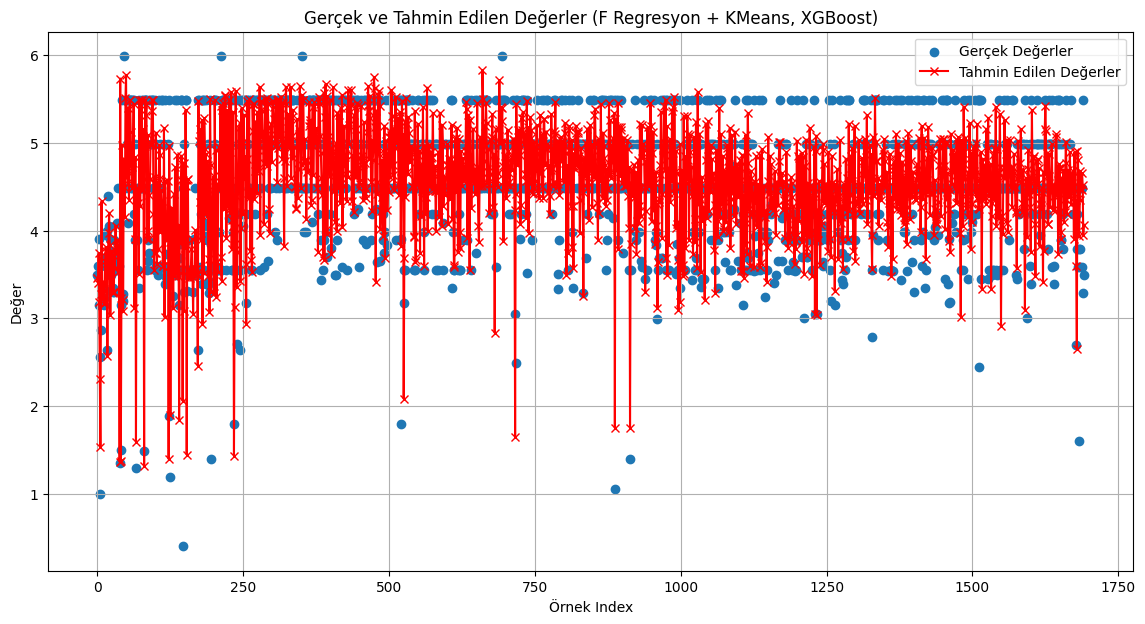

In [15]:
plt.figure(figsize=(14,7))
plt.scatter(np.arange(len(y)), y, label="Gerçek Değerler", marker="o")
plt.plot(np.arange(len(y)), all_predictions.sort_index(), label="Tahmin Edilen Değerler", marker="x", color="red", linestyle="-")
plt.xlabel("Örnek Index")
plt.ylabel("Değer")
plt.title("Gerçek ve Tahmin Edilen Değerler (F Regresyon + KMeans, XGBoost)")
plt.legend()
plt.grid(True)
plt.show()